# Experiment 5

## Goal 

Running Gradient descent for multiple variables of the FHN model

Make FHN functions available

In [1]:
import sys
sys.path.insert(0, '../../')

import modules

In [2]:
import torch as t
import numpy as np
from experiment_helper import chop_and_shuffle_data, generate_sequence
from diffusion_gumbel import diffuse_STE
from reaction_diff import rho_STE
from tqdm import tqdm
import matplotlib.pyplot as plt
import os 
from os import path, getcwd
import time
import imageio
import random

set device

In [3]:
device = t.device('cuda' if t.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


generate data

In [5]:
grid = t.zeros((2, 64, 64), device=device)
grid[:] = 25
grid[0, 29:35] = 40

gamma = 0.005
k1 = k1_bar = 0.98
k2 = k2_bar = 0.1
k3 = k3_bar = 0.2

N = 50
num_steps = 50_000
DA = 0.1
DB = 0.4

generate_sequence(
    grid,
    num_steps,
    N,
    use_diffusion=True,
    DA=DA,
    DB=DB,
    use_reaction=True,
    gamma=gamma,
    k1=k1,
    k1_bar=k1_bar,
    k2=k2,
    k2_bar=k2_bar,
    k3=k3,
    k3_bar=k3_bar,
    create_vis=False,
    save_steps=True,
    create_seq=False,
)


  0%|          | 0/50000 [00:00<?, ?it/s]c:\Users\jsche\anaconda3\envs\torchenv\lib\site-packages\torch\distributions\distribution.py:167: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)
100%|██████████| 50000/50000 [10:00<00:00, 83.26it/s]  


use last datapoint from the simulation as reference state

In [6]:
data_dir = path.join(getcwd(), "data", "1674905783.5314908")
ref_state = t.load(path.join(data_dir, "batch_500", "0.pt"), map_location=device)

torch.Size([2, 64, 64])


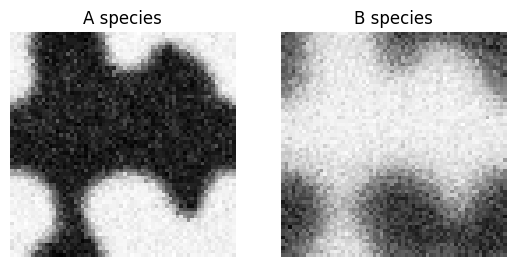

In [7]:
print(ref_state.shape)
fig, axs = plt.subplots(1,2)
axs[0].imshow(ref_state[0].cpu(),cmap="Greys",interpolation="nearest",vmin=0,vmax=50)
axs[0].set_title("A species")
axs[0].axis("off")
axs[1].imshow(ref_state[1].cpu(),cmap="Greys",interpolation="nearest",vmin=0,vmax=50)
axs[1].set_title("B species")
axs[1].axis("off")
plt.show()

define a distance function

In [14]:
def loss_fn(X, Y):
    return t.log(t.sum((X[:, 0] - Y[:,0])**2 + (X[:, 1] - Y[:,1])**2, dim=(0,1,2)))

define the params

In [15]:
from torch.distributions import uniform
param_sampler = uniform.Uniform(0,1)

k1 = param_sampler.sample().to(device)
k2 = param_sampler.sample().to(device)
k3 = param_sampler.sample().to(device)

define training function

In [16]:
DA = t.tensor(0.1, device=device)
DB = t.tensor(0.4, device=device)
gamma = 0.005
N = 50

if ref_state.ndim == 3:
    ref_state = ref_state.unsqueeze(0)

k1_vals = [k1.detach().cpu().numpy()]
k2_vals = [k2.detach().cpu().numpy()]
k3_vals = [k3.detach().cpu().numpy()]
losses = []
grads_k1 = []
grads_k2 = []
grads_k3 = []

In [34]:
for i in tqdm(range(500)):
    X = ref_state.detach().clone()
    
    k1.requires_grad_()
    k2.requires_grad_()
    k3.requires_grad_()
    
    # Make predictions for this batch
    for sim_step in range(1200):
        # run the diffusion step
        X = diffuse_STE(X, N, DA, DB)
        # run the reaction step
        X = rho_STE(X, N, gamma, k1, k1, k2, k2, k3, k3)
        
    # Compute the loss and its gradients
    loss = loss_fn(ref_state, X)
    grad_k1, grad_k2, grad_k3 = t.autograd.grad(loss, (k1, k2, k3))

    k1 = k1 - 0.1 * grad_k1
    k2 = k2 - 0.001 * grad_k2
    k3 = k3 - 0.01 * grad_k3
        
    with t.no_grad():
        k1 = k1.clamp(0, 1)
        k2 = k2.clamp(0, 1)
        k3 = k3.clamp(0, 1)
    
    k1_vals.append(k1.detach().cpu().numpy())
    k2_vals.append(k2.detach().cpu().numpy())
    k3_vals.append(k3.detach().cpu().numpy())
    losses.append(loss.detach().cpu().numpy())
    grads_k1.append(grad_k1.detach().cpu().numpy())
    grads_k2.append(grad_k2.detach().cpu().numpy())
    grads_k3.append(grad_k3.detach().cpu().numpy())

100%|██████████| 500/500 [2:25:15<00:00, 17.43s/it]  


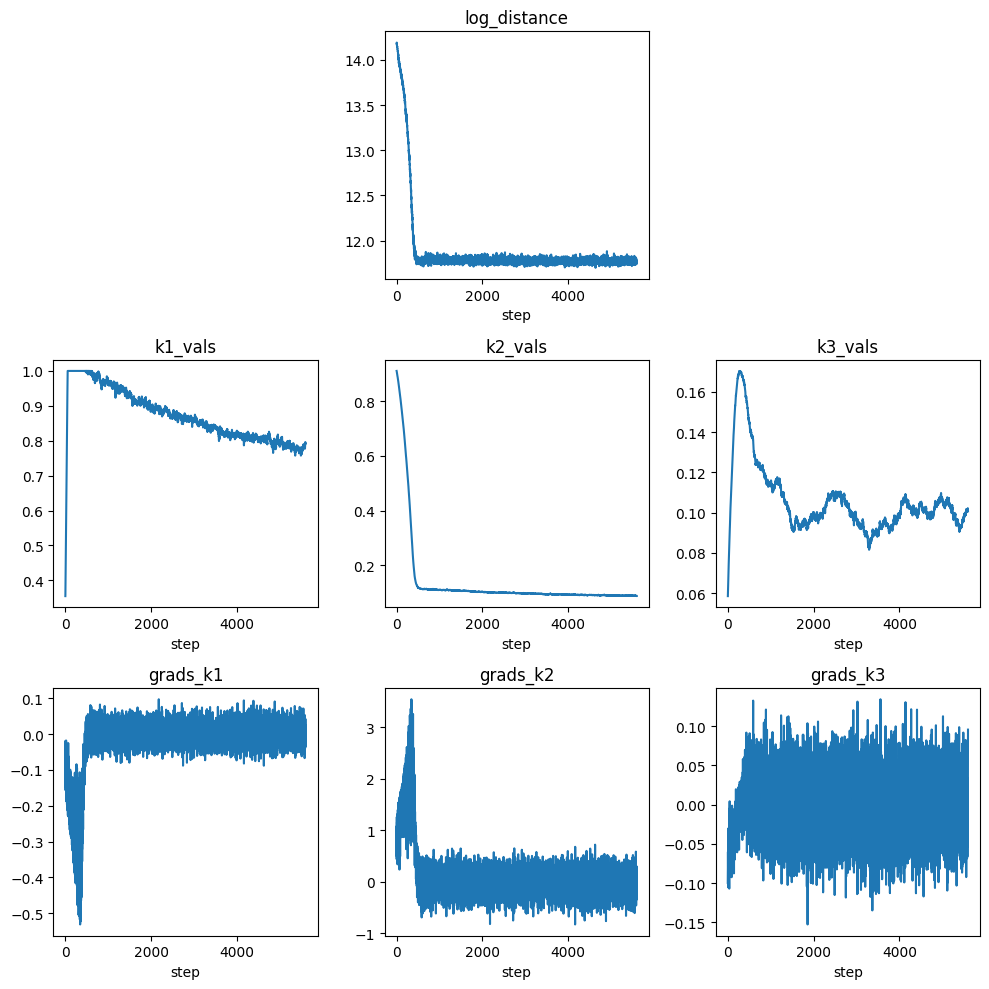

In [35]:
fig, axs = plt.subplots(3,3, figsize=(10,10))

axs[0,1].plot(np.arange(5600), losses)
axs[0,1].set_title("log_distance")
axs[0,1].set_xlabel("step")
axs[0,0].axis("off")
axs[0,2].axis("off")

axs[1,0].plot(np.arange(5601), k1_vals)
axs[1,0].set_title("k1_vals")
axs[1,0].set_xlabel("step")
axs[2,0].plot(np.arange(5600), grads_k1)
axs[2,0].set_title("grads_k1")
axs[2,0].set_xlabel("step")

axs[1,1].plot(np.arange(5601), k2_vals)
axs[1,1].set_title("k2_vals")
axs[1,1].set_xlabel("step")
axs[2,1].plot(np.arange(5600), grads_k2)
axs[2,1].set_title("grads_k2")
axs[2,1].set_xlabel("step")

axs[1,2].plot(np.arange(5601), k3_vals)
axs[1,2].set_title("k3_vals")
axs[1,2].set_xlabel("step")
axs[2,2].plot(np.arange(5600), grads_k3)
axs[2,2].set_title("grads_k3")
axs[2,2].set_xlabel("step")

fig.tight_layout()
plt.show()

In [44]:
np.save("param_trace.npy", np.array([k1_vals, k2_vals, k3_vals]))
np.save("results.npy", np.array([losses, grads_k1, grads_k2, grads_k3]))

In [37]:
print(k1, k2, k3)

tensor(0.7912, device='cuda:0') tensor(0.0885, device='cuda:0') tensor(0.1006, device='cuda:0')


Turn every 100 training steps into a gif

In [5]:
param_trace = np.load("param_trace.npy")
param_trace.shape

(3, 5601)

In [6]:
N = 50
num_steps = 50_000
DA = 0.1
DB = 0.4
gamma = 0.005

param_idx = 750
while param_idx < 2_000:
    k1 = k1_bar = param_trace[0, param_idx]
    k2 = k2_bar = param_trace[1, param_idx]
    k3 = k3_bar = param_trace[2, param_idx]
    
    grid = t.zeros((2, 64, 64), device=device)
    grid[:] = 25
    grid[0, 29:35] = 40
    
    im_dir = f"k1_{k1:.2f}_k2_{k2:.2f}_k3_{k3:.2f}_step{param_idx}"
    im_path = path.join(getcwd(), "im", im_dir)
    
    generate_sequence(
        grid,
        num_steps,
        N,
        use_diffusion=True,
        DA=DA,
        DB=DB,
        use_reaction=True,
        gamma=gamma,
        k1=k1,
        k1_bar=k1_bar,
        k2=k2,
        k2_bar=k2_bar,
        k3=k3,
        k3_bar=k3_bar,
        create_vis=True,
        save_steps=False,
        create_seq=False,
        im_path=im_path
    )
    
    param_idx += 50
    

  0%|          | 0/50000 [00:00<?, ?it/s]c:\Users\jsche\anaconda3\envs\torchenv\lib\site-packages\torch\distributions\distribution.py:167: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)
  0%|          | 62/50000 [00:00<11:44, 70.88it/s] 


KeyboardInterrupt: 

In [ ]:
import imageio

im_path = path.join(getcwd(), "im")
dirnames = os.listdir(im_path)

for i in tqdm(range(len(dirnames))):
    images = []
    im_counter = 0
    trace_name = [s for s in dirnames if f"step{i*50}" in s][0]
    full_path = path.join(im_path, trace_name)
    while im_counter < 50_000:
        images.append(imageio.imread(path.join(full_path, f"{im_counter}.png")))
        im_counter +=  100
    imageio.mimsave(path.join(getcwd(), "gif", f"{trace_name}.gif"), images)

In [26]:
dirnames

['k1_0.35_k2_0.91_k3_0.06_step0',
 'k1_0.95_k2_0.11_k3_0.12_step850',
 'k1_0.96_k2_0.11_k3_0.12_step1000',
 'k1_0.97_k2_0.11_k3_0.11_step950',
 'k1_0.97_k2_0.11_k3_0.12_step900',
 'k1_0.97_k2_0.86_k3_0.09_step50',
 'k1_0.98_k2_0.11_k3_0.12_step650',
 'k1_0.98_k2_0.11_k3_0.12_step700',
 'k1_0.98_k2_0.11_k3_0.12_step750',
 'k1_0.98_k2_0.11_k3_0.12_step800',
 'k1_0.99_k2_0.11_k3_0.13_step600',
 'k1_1.00_k2_0.12_k3_0.14_step500',
 'k1_1.00_k2_0.12_k3_0.14_step550',
 'k1_1.00_k2_0.14_k3_0.15_step450',
 'k1_1.00_k2_0.19_k3_0.16_step400',
 'k1_1.00_k2_0.31_k3_0.17_step350',
 'k1_1.00_k2_0.43_k3_0.17_step300',
 'k1_1.00_k2_0.54_k3_0.17_step250',
 'k1_1.00_k2_0.64_k3_0.16_step200',
 'k1_1.00_k2_0.72_k3_0.15_step150',
 'k1_1.00_k2_0.80_k3_0.12_step100']